- *Nombre Alumno/a*:
- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2023/2024
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Optimización del Scheduling con Machine Learning (Parte 3/3)

En los pasos anteriores se han desarrollado modelos predictivos tanto de consignas del horno (THC1, THC3 y THC5) como de comportamiento de la bobina de acero (TMPP2).

¿Cómo podemos usar estos modelos en la toma de decisiones?

Imaginemos que el jefe de producción nos pide que, para maximizar la producción, **organicemos las bobinas que tenemos que procesar mañana considerando una velocidad constante de 180 metros por minuto.**

Pero sabemos que **un tratamiento de temperatura homogéneo es crucial para reducir los problemas de adherencia de la capa de zinc**.

Para reducir problemas en el recubrimiento de zinc, el orden (*scheduling*) de las bobinas deberá ser hecho de la mejor forma posible, de modo que **los cambios en las temperaturas de consigna de THC1 se minimicen para evitar problemas en el tratamiento térmico**.

En esta tercera parte, vamos a aprender cómo utilizar los modelos de machine learning para simular el proceso industrial y optimizarlo en base a unas especificaciones previas.

Las bobinas a procesar en el futuro próximo corresponden con las 81 bobinas de la base de datos de testeo por lo que, en un hipotético caso real, **solo dispondríamos de la información relativa a cada bobina (dimensiones, tipo de acero) y los datos objetivos (velocidad objetivo y temperatura objetivo que tiene que alcanzar la bobina a la salida del horno según la curva de recocido de cada tipo de acero)**.

In [5]:
# Importamos paquetes basicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

## Funciones

In [6]:
# Dibuja datos del proceso
def dibuja_proceso(df, pos_ini = 0, num_bobs = None):
    if num_bobs==None:
        num_bobs = len(df)
    # Dibuja Espesor y Ancho con dos ejes
    # -----------------------------------
    df_plot = df.iloc[pos_ini:pos_ini+num_bobs]

    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
    ax.plot(df_plot['ESPESOR'], label='ESPESOR')
    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Espesor (mm.)')
    # Segundo eje
    ax.plot(df_plot['ANCHO']/1000.0, label='ANCHO')
    def CtoF(x):
        return x * 1000.0
    def FtoC(x):
        return x / 1000.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Ancho (mm.)')
    ax.legend()

    # Dibuja Temperaturas y Velocidad con dos ejes
    # -----------------------------------
    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
    for colname in df_plot.columns[7:]:
        ax.plot(df_plot[colname], label=colname)

    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Temperaturas (ºC)')

    ax.plot(df_plot['VELMED']*3.0, label='VELMED')
    def CtoF(x):
        return x / 3.0
    def FtoC(x):
        return x * 3.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Velocidad Media (m/min)')
    ax.legend()

# Dibuja predicciones de un modelo
def dibuja_preds(y_true, y_pred, mae, rmse, r2tst, titulo='Real vs Prediccion'):
    titulo = titulo+'MAE:{:.3f}, RMSE:{:,.3f}, R2:{:,.3f}'.format(mae, rmse, r2tst)
    plt.figure(figsize=(8,8))
    # Diagonal
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    # Preds vs Real
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true,y_pred,alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.title(titulo)
    plt.show()


# Dibuja cuatro graficas de preds vs real
from sklearn.metrics import r2_score

def saca_predicciones(y_true, y_pred, num_data=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    r_corr = np.corrcoef(y_true, y_pred)[0,1]

    residuos = y_pred-y_true
    df = pd.DataFrame({'Real':y_true,'Prediccion':y_pred, 'Residuos':residuos})
    if num_data!=None:
        df = df.sample(num_data)

    fig, axs = plt.subplots(figsize=(11,11), nrows=2, ncols=2)
    fig.tight_layout(pad=3.0)

    min_x, max_x = df.Real.min(), df.Real.max()
    fig3 = sns.scatterplot(ax=axs[0,0], x=df.Real, y=df.Prediccion, alpha=0.70, data=df)
    fig3 = sns.regplot(ax=axs[0,0], x='Real', y='Prediccion', scatter=False, data=df, color='red', line_kws={'linewidth': 2})
    fig3.set_xlabel('Real')
    fig3.set_ylabel('Predicción')
    fig3.set_ylim((df.Prediccion.min(), df.Prediccion.max()))
    fig3.set_xlim((df.Real.min(), df.Real.max()))
    fig3.plot([0, max_x],[0, max_x], color='black', linestyle='--')
    fig3.set_title('MAE={:,.4f}, RMSE={:,.4f}, R={:,.4f}, R2={:,.4f}'.format(mae, rmse, r_corr,r2))

    fig1 = sns.histplot(ax=axs[0,1], x='Prediccion', data=df, kde=True)
    fig1.set_title('MIN={:,.3f}, MAX={:,.3f}'.format(df.Prediccion.min(),df.Prediccion.max()))
    fig1.set_xlabel('Prediccion')
    fig1.set_ylabel('Num')

    min_x, max_x = df.Real.min(), df.Real.max()
    fig2 = sns.scatterplot(ax=axs[1,0], x=df.Real[np.argsort(df.Real)], y=df.Residuos[np.argsort(df.Real)], alpha=0.70, data=df)
    fig2 = sns.regplot(ax=axs[1,0], x='Real', y='Residuos', scatter=False, data=df, color='red', line_kws={'linewidth': 2})
    fig2.set_xlabel('Real')
    fig2.set_ylabel('Residuos')
    fig2.set_ylim((df.Residuos.min(), df.Residuos.max()))
    fig2.plot([min_x, max_x],[0, 0], color='black', linestyle='--')
    fig2.set_title('MEAN={:,.3f}, STD={:,.3f}'.format(np.mean(df.Residuos),np.std(df.Residuos)))


    fig4 = sns.histplot(ax=axs[1,1], x='Residuos', data=df, kde=True)
    fig4.set_xlabel('Residuos')
    fig4.set_ylabel('Num')
    fig4.set_title('MIN={:,.4f}, MAX={:,.4f}'.format(df.Residuos.min(), df.Residuos.max()))


# Función que obtiene el MAE, RMSE y R2 de VC con repetición y para la base de datos de testeo
def entrena_model(model, num_folds=5, num_bags=10, features=None):
    np.random.seed(2020)
    X_tot = df_train_esc[features].values.copy()
    y_tot = df_train_limpia[target].values.reshape(-1)
    X_test = df_test_esc[features].values.copy()
    y_test = df_test[target].values.reshape(-1)

    # Creamos arrays para las predicciones
    preds_val = np.empty((len(X_tot),num_bags))
    preds_val[:] = np.nan
    preds_test = np.empty((len(X_test),num_bags*num_folds))
    preds_test[:] = np.nan
    # Entrena y extrae la predicciones con validación cruzada repetida

    folds = RepeatedKFold(n_splits=num_folds, n_repeats=num_bags, random_state=2020)
    for niter, (train_index, val_index) in enumerate(folds.split(X_tot, y_tot)):
        nbag = niter//num_folds #Extrae el número de repetición (bag)
        X_train, X_val = X_tot[train_index], X_tot[val_index]
        y_train, y_val = y_tot[train_index], y_tot[val_index]
        model.fit(X_train, y_train)
        preds_val[val_index,nbag] = model.predict(X_val)
        preds_test[:,niter] = model.predict(X_test)

    # Promedia las predicciones
    preds_val_mean = preds_val.mean(axis=1)
    preds_test_mean = preds_test.mean(axis=1)

    # Extrae las métricas
    mae_val = mean_absolute_error(y_tot, preds_val_mean)
    rmse_val = np.sqrt(mean_squared_error(y_tot, preds_val_mean))
    r2_val = r2_score(y_tot, preds_val_mean)

    mae_tst = mean_absolute_error(y_test, preds_test_mean)
    rmse_tst = np.sqrt(mean_squared_error(y_test, preds_test_mean))
    r2_tst = r2_score(y_test, preds_test_mean)
    return dict(mae_val=mae_val, rmse_val=rmse_val, r2_val=r2_val, mae_tst=mae_tst, rmse_tst=rmse_tst, r2_tst=r2_tst,
                y_tot=y_tot, preds_val_mean=preds_val_mean, y_test=y_test, preds_test_mean=preds_test_mean, preds_val=preds_val, preds_test=preds_test)

## Leemos la Base de Datos y Preprocesamos

In [7]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2024-04-26 16:56:42--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2024-04-26 16:56:42--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.01s   

2024-04-26 16:56:42 (8.35 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2024-04-26

In [8]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')

df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

df_train = df_train.loc[df_train['VELMED']<500] # Nos quedamos con los casos menores de 500
display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


## Definición del Problema

Las bobinas a procesar son las que tenemos en la base de datos de testeo.

El jefe de producción no indica que necesitamos mejorar el proceso de producción **aumentando la velocidad de producción a 180 metros por minuto**. Para ello, tenemos que determinar las cosignas de THC1, THC3, THC5 que permitan poder procesar las bobinas de forma óptima.

Así mismo, nos pide que **reorganicemos el *scheduling* de las mismas para que los cambios en THC1 sean lo menos bruscos posibles**.

Imaginemos, que las bobinas no han sido tratadas aún y que **solo disponemos de las variables correspondientes a la bobina (CLASACERO, ANCHO, ESPESOR, LARGO, PESO), la temperatura a la que tiene que salir la bobina del horno (TMPP2CNG), que proviene de la curva de recocido del tipo de acero, y la velocidad objetivo que es VELMED=180.**

Es decir, de la base de datos de testeo tenemos que cambiar o eliminar la siguiente información.


(81, 13)


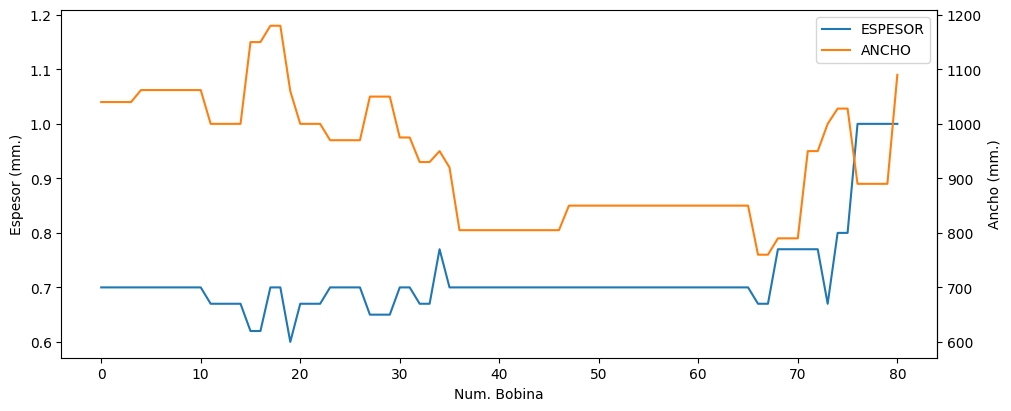

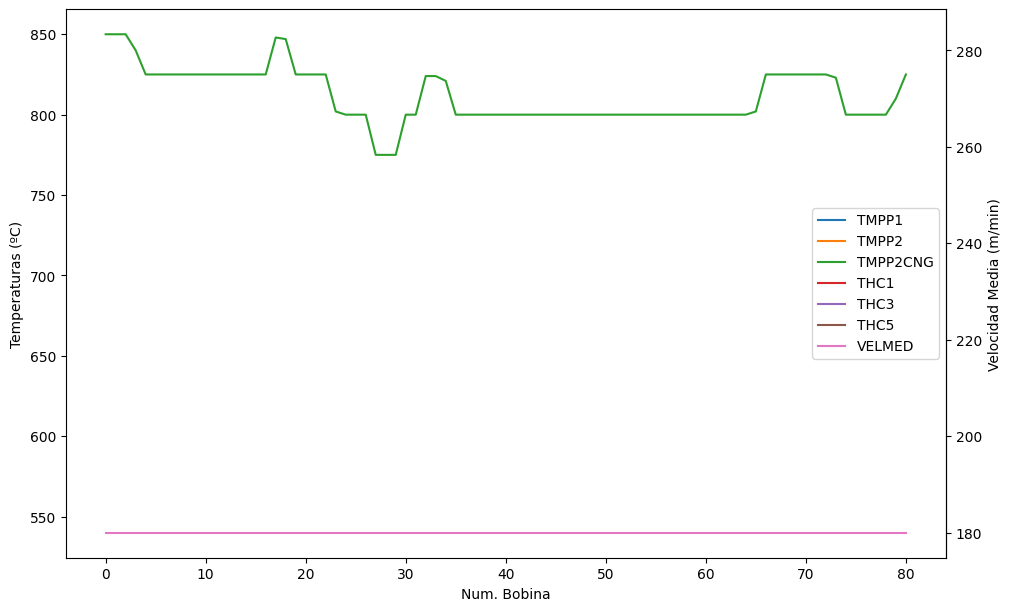

In [9]:
# Recogemos los datos de la base de datos de testeo y eliminamos aquellos que no podríamos saber.
df_test_sin_procesar = df_test.copy()
df_test_sin_procesar['VELMED'] = 180.0 #El objetivo es producir a 180m/min
df_test_sin_procesar['THC1'] = np.nan #Deberíamos calcularla
df_test_sin_procesar['THC3'] = np.nan #Deberíamos calcularla
df_test_sin_procesar['THC5'] = np.nan #Deberíamos calcularla
df_test_sin_procesar['TMPP1'] = np.nan #No disponemos de ella previamente
df_test_sin_procesar['TMPP2'] = np.nan #No disponemos de ella previamente
print(df_test_sin_procesar.shape)
dibuja_proceso(df_test_sin_procesar)

**El objetivo es conseguir un tratamiento de temperatura de THC1 lo más homogéneo posible para reducir los problemas debidos a cambios bruscos de temperatura en el tratamiento de las bobinas**

Como THC3 y THC5 están muy correladas con THC1, es posible que, al reducir los saltos en THC1 se reduzcan los saltos en THC3 y THC5.

Después de la reunión con los tecnólogos de la empresa se decide realizar los siguientes pasos:

1. Crear los mejores modelos A posibles para THC1, THC3 y THC5, usando la metodología utilizada en la parte 2.
2. Crear un modelo B, que permita predecir la temperatura de salida de la bobina (TMPP2) a partir de las características de la bobina (CLASACERO, ANCHO, ESPESOR), THC1, THC3, THC5 y VELMED.
3. Determinar los valores de THC1, THC3, THC5 para cada bobina si queremos tratarlas a VELMED=180.
4. Una vez tenemos THC1, THC3, THC5, usar el modelo B para calcular TMPP2.
5. Mediante simulación, usar diferentes estrategias para reorganizar el orden (*scheduling*) de las bobinas con el objetivo de minimizar los saltos de temperatura de TMPP2 entre bobinas.

## Creación de los Modelos para predecir la temperatura en las zonas 1, 3, y 5 del horno (THC1, THC3, THC5)

Creamos una nueva base de datos de testeo fijando VELMED a 180 m/min. Así, las predicciones de THC1, THC3 y THC5 de los modelos serán con la velocidad objetivo de 180 metros por minuto. Para la base de datos de entrenamiento, quitamos los casos con diferencias mayores de 25 grados entre TMPP2 y TMPP2CNG.

In [10]:
df_train_limpia = df_train.loc[np.abs(df_train['TMPP2CNG']-df_train['TMPP2'])<=25].copy()
df_dummies = pd.get_dummies(pd.concat([df_train_limpia['CLASACERO'], df_test['CLASACERO']]))
df_train_limpia_cat = df_train_limpia.join(df_dummies.iloc[:len(df_train_limpia)])

df_test_cat = df_test.join(df_dummies.iloc[len(df_train_limpia):])
df_test_cat['VELMED'] = 180.0 #Ponemos a 180 la base de datos de testeo para obtener las THC1, THC3, THC5

selec_features = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP2CNG'] + list(df_dummies.columns)

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train_limpia_cat[selec_features].values)
df_train_esc = scaler.transform(df_train_limpia_cat[selec_features].values)
df_train_esc = pd.DataFrame(df_train_esc, columns=selec_features)
df_test_esc = scaler.transform(df_test_cat[selec_features].values)
df_test_esc = pd.DataFrame(df_test_esc, columns=selec_features)
print(df_train_esc.shape, df_test_esc.shape)

(1851, 50) (81, 50)


**EJERCICIO: Obtenemos de nuevo los modelos para THC1, THC3 y THC5 utilizando el algoritmo seleccionado en la parte 2/3, los hiperparámetros y las características seleccionadas para cada uno. Los modelos tienen que llamarse: modelo_thc1, modelo_thc3, modelo_thc5**

En este ejemplo usamos el modelo lineal básico, *Ridge* y todas las features.

**El alumno deberá usar el mejor algoritmo, los hiperparámetros más adecuados y las features para cada caso obtenidos en la parte 2/3 de este proyecto**.

In [11]:
target = 'THC1'
modelo_thc1 = Ridge()
selected_feats_thc1 = selec_features.copy() # Sustituir por las feats de la parte 2/3 para THC1
res = entrena_model(modelo_thc1, num_folds=5, num_bags=10, features=selected_feats_thc1)
y_test1 = res['y_test']
preds_test1 = res['preds_test_mean']


target = 'THC3'
modelo_thc3 = Ridge()
selected_feats_thc3 = selec_features.copy() # Sustituir por las feats de la parte 2/3 para THC3
res = entrena_model(modelo_thc3, num_folds=5, num_bags=10, features=selected_feats_thc3)
y_test3 = res['y_test']
preds_test3 = res['preds_test_mean']


target = 'THC5'
modelo_thc5 = Ridge()
selected_feats_thc5 = selec_features.copy() # Sustituir por las feats de la parte 2/3 para THC5
res = entrena_model(modelo_thc5, num_folds=5, num_bags=10, features=selected_feats_thc5)
y_test5 = res['y_test']
preds_test5 = res['preds_test_mean']

## Creación del Modelo B para predecir la temperatura de salida de la banda de acero (TMPP2)

Creamos la base de datos de testeo modificando THC1, THC3, THC5 que han sido obtenidos con los modelos anteriores. Así mismo, ponemos VELMED=180.

Para la base de datos de entrenamiento **no eliminamos los casos cuya diferencia sea mayor de 25ºC**, pues queremos aprender el comportamiento de la banda de acero antes los diversos puntos de operación del proceso.

In [12]:
df_train_limpia = df_train.copy()
df_dummies = pd.get_dummies(pd.concat([df_train_limpia['CLASACERO'], df_test['CLASACERO']]))
df_train_limpia_cat = df_train_limpia.join(df_dummies.iloc[:len(df_train_limpia)])
df_test_cat = df_test.join(df_dummies.iloc[len(df_train_limpia):])
df_test_cat['VELMED'] = 180.0 #Velocidad Prefijada
df_test_cat['THC1'] = preds_test1 #Predicción del modelo_thc1
df_test_cat['THC3'] = preds_test3 #Predicción del modelo_thc3
df_test_cat['THC5'] = preds_test5 #Predicción del modelo_thc5

selec_features = ['ANCHO', 'ESPESOR', 'VELMED', 'THC1', 'THC3', 'THC5'] + list(df_dummies.columns)

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train_limpia_cat[selec_features].values)
df_train_esc = scaler.transform(df_train_limpia_cat[selec_features].values)
df_train_esc = pd.DataFrame(df_train_esc, columns=selec_features)
df_test_esc = scaler.transform(df_test_cat[selec_features].values)
df_test_esc = pd.DataFrame(df_test_esc, columns=selec_features)
print(df_train_esc.shape, df_test_esc.shape)

(1894, 52) (81, 52)


**EJERCICIO: Obtenemos de nuevo el modelo para TMPP2 utilizando el algoritmo seleccionado en la parte 2/3, hiperparámetros y features seleccionadas. El modelo se llamará: modelo_tmpp2**

Como ejemplo usamos uno básico, *Ridge*.

El alumno deberá usar el mejor algoritmo, caracteristicas de entrada e hiperparámetros obtenidos en la parte 2/3 para el modelo TMPP2.

In [13]:
target = 'TMPP2'
model_tmpp2 = Ridge()
selected_feats_tmpp2 = selec_features.copy() # Sustituir por las feats de la parte 2/3 para TMPP2
res = entrena_model(model_tmpp2, num_folds=5, num_bags=10, features=selected_feats_tmpp2)
preds_test_tmpp2 = res['preds_test_mean']

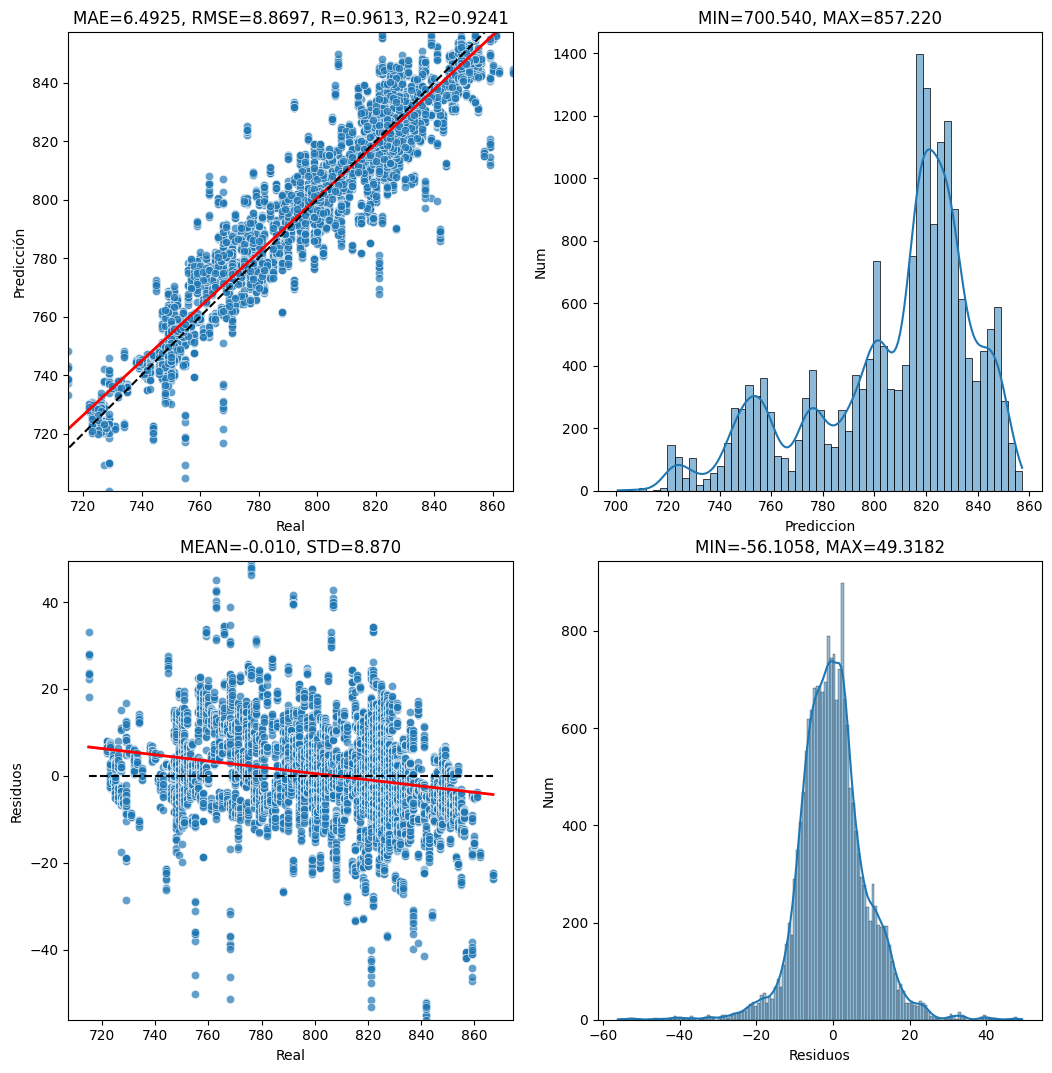

In [14]:
# Visualiza los errores de validación cruzada repetida 10 veces
num_bags = 10
y_true_rep = np.array(list(res['y_tot'])*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = res['preds_val'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

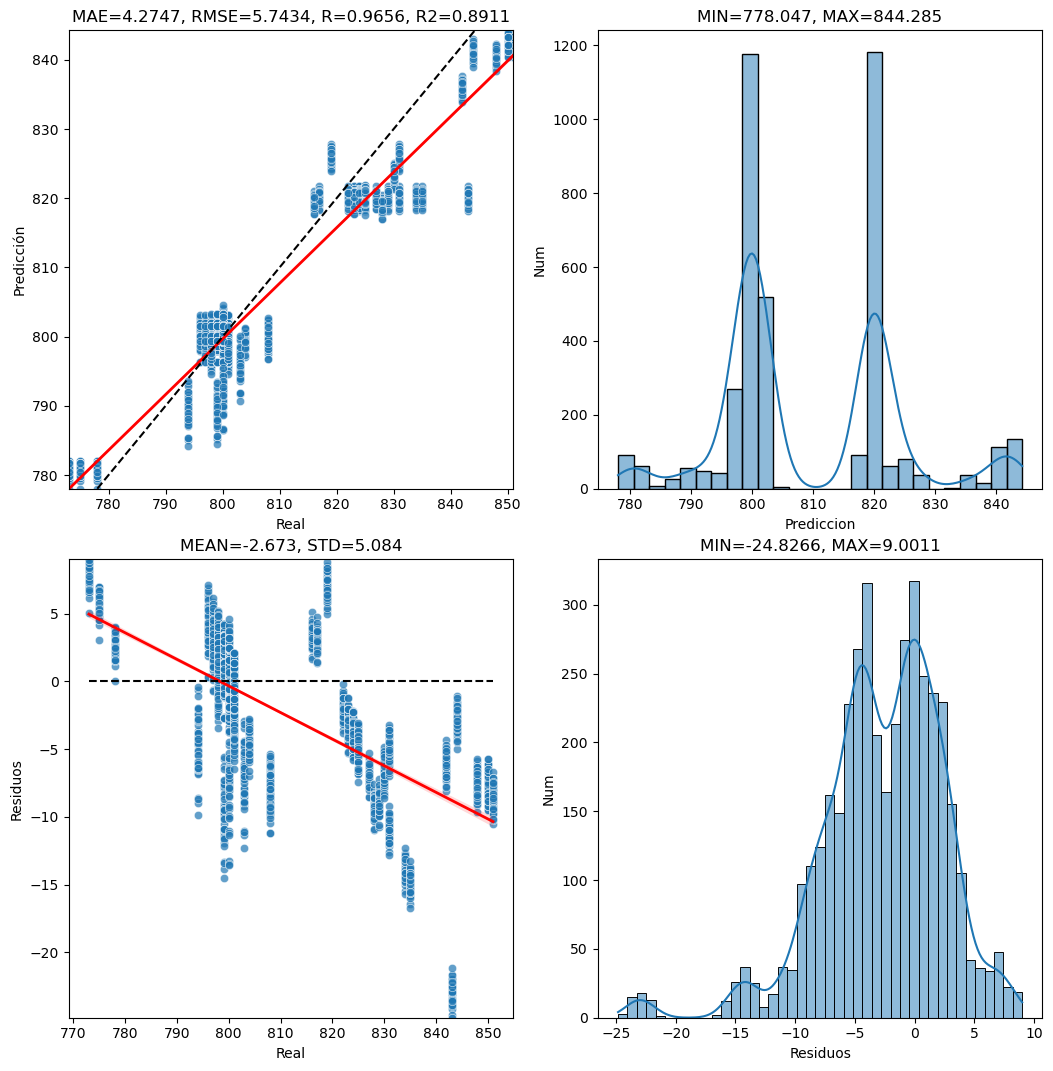

In [ ]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = 5
y_true_rep = np.array(list(res['y_test'])*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = res['preds_test'].flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

Dibujamos la simulación del proceso con las predicciones de THC1, THC3, THC5, TMPP2 si fijamos VELMED a 180m/min.

Obtenemos la diferencia máxima entre TMPP2 y TMPP2CNG, y vemos que es menor de los 25ºC.

De este modo, la simulación nos indica que todas las bobinas van a poder ser tratadas correctamente.

DIFERENCIA MAXIMA ENTRE TMPP2CNG y TMPP2= 14.121585013241429


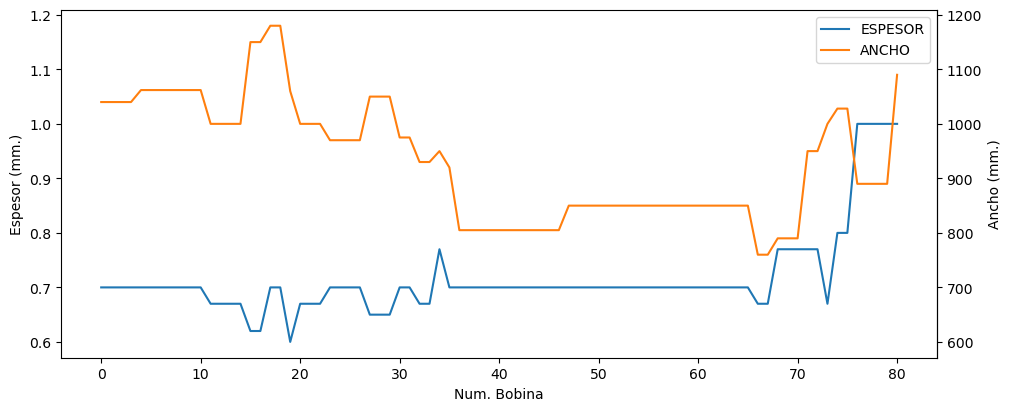

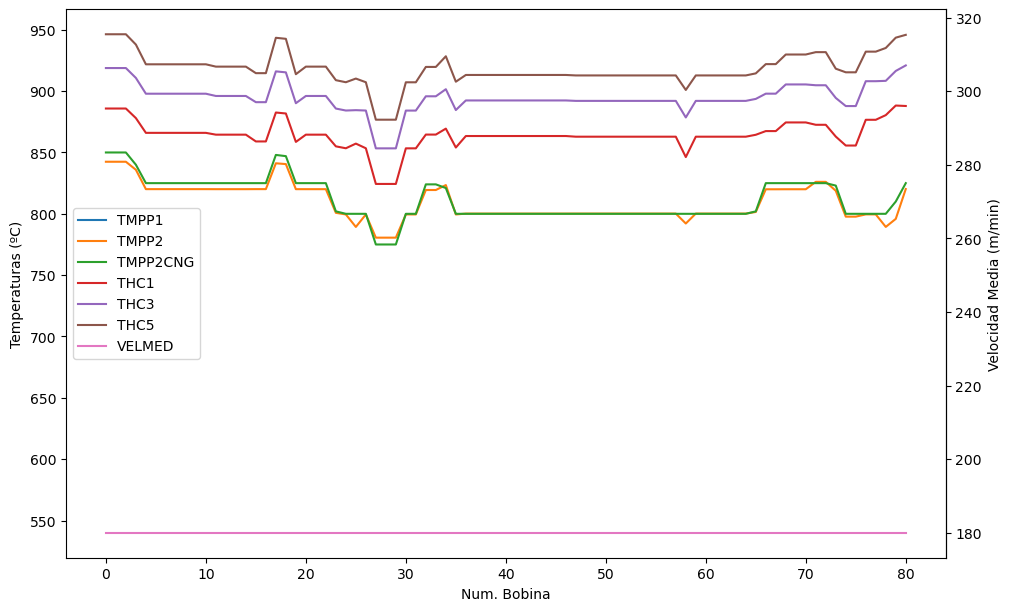

In [ ]:
df_test_cat['TMPP2'] = preds_test_tmpp2
df_test_cat['TMPP1'] = np.nan
print('DIFERENCIA MAXIMA ENTRE TMPP2CNG y TMPP2=',np.max(np.abs(df_test_cat['TMPP2CNG']-df_test_cat['TMPP2'])))
dibuja_proceso(df_test_cat[df_test.columns])

## Optimización del Scheduling de Bobinas para Minimizar los Saltos Térmicos de THC1

El segundo objetivo es minimizar los saltos de THC1. Como THC1, THC3 y THC5 están muy correladas entre sí, si minimizamos los saltos de THC1 se minimizarán los saltos térmicos de las otras dos variables.

Podemos calcular la suma de la diferencias de temperaturas fácilmente:

In [15]:
def calcula_diff(thc1, var):
    suma_diff = thc1.diff().abs().sum()
    print(f'Suma de differencias en valor absoluto de {var} entre bobinas consecutivas={suma_diff:,.2f}')

calcula_diff(df_test_cat['THC1'],'THC1')
calcula_diff(df_test_cat['THC3'],'THC3')
calcula_diff(df_test_cat['THC5'],'THC5')

Suma de differencias en valor absoluto de THC1 entre bobinas consecutivas=295.09
Suma de differencias en valor absoluto de THC3 entre bobinas consecutivas=292.59
Suma de differencias en valor absoluto de THC5 entre bobinas consecutivas=313.54


La máxima minimización de los saltos de THC1 la obtendríamos ordenando las bobinas según THC1, tal y como se puede observar en las siguientes celdas.

Vemos que el mínimo valor de saltos en THC1 es una suma de 64ºC en total.

Sin embargo, vemos que existe un enorme desorden de las bobinas con muchos saltos entre espesores y anchos de bobina.

Suma de differencias en valor absoluto de THC1 entre bobinas consecutivas=63.91
Suma de differencias en valor absoluto de THC3 entre bobinas consecutivas=88.10
Suma de differencias en valor absoluto de THC5 entre bobinas consecutivas=106.44


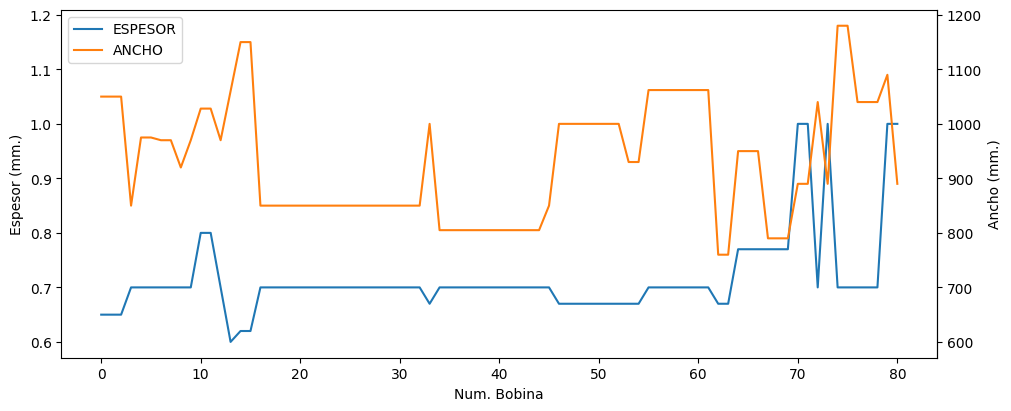

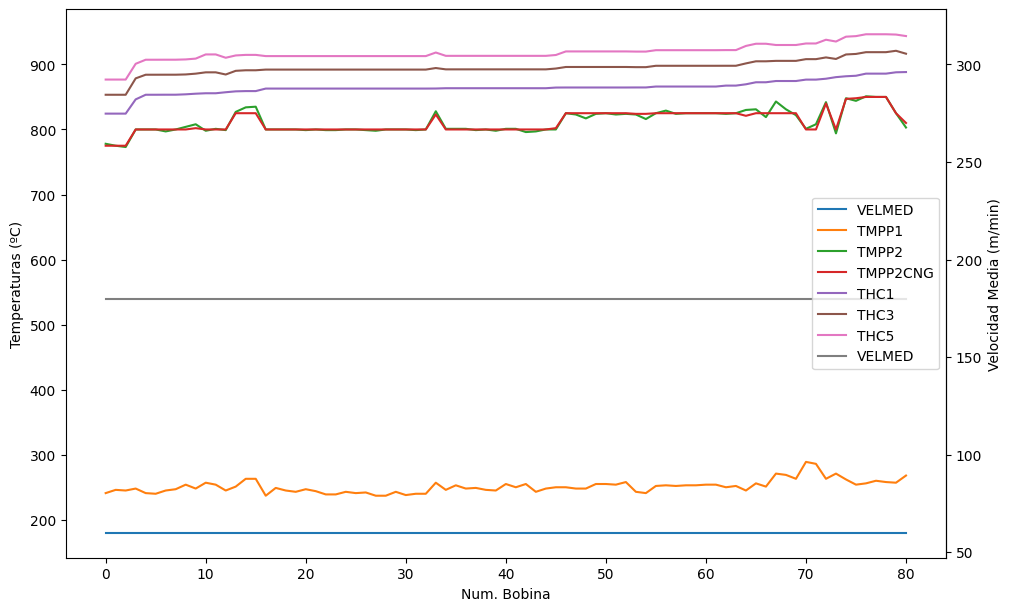

In [16]:
calcula_diff(df_test_cat.sort_values(['THC1'])['THC1'],'THC1')
calcula_diff(df_test_cat.sort_values(['THC1'])['THC3'],'THC3')
calcula_diff(df_test_cat.sort_values(['THC1'])['THC5'],'THC5')

dibuja_proceso(df_test_cat[df_test.columns].sort_values(['THC1']).reset_index())

In [ ]:
df_test_cat[df_test.columns].sort_values(['THC1']).head(10)

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
29,23643026,B102G33,1050.0,0.65,3739.0,20180.0,180.0,NaN,780.569347,775.0,824.349056,853.353793,876.715864
28,23643025,B102G33,1050.0,0.65,2881.0,15430.0,180.0,NaN,780.569347,775.0,824.349056,853.353793,876.715864
27,23643024,B102G33,1050.0,0.65,3531.0,19130.0,180.0,NaN,780.569347,775.0,824.349056,853.353793,876.715864
58,23643055,K011B55,850.0,0.70,3432.0,15970.0,180.0,NaN,792.099966,800.0,846.253579,878.548738,900.964783
31,23643028,B102G55,975.0,0.70,3633.0,19520.0,180.0,NaN,799.486537,800.0,853.366815,884.148711,907.204507
30,23643027,B102G55,975.0,0.70,3390.0,18110.0,180.0,NaN,799.486537,800.0,853.366815,884.148711,907.204507
26,23643023,B102G55,970.0,0.70,2659.0,14260.0,180.0,NaN,799.484747,800.0,853.427529,884.187841,907.247164
24,23643021,B102G55,970.0,0.70,2878.0,15360.0,180.0,NaN,799.484747,800.0,853.427529,884.187841,907.247164
35,23643032,B102G55,920.0,0.70,3209.0,16390.0,180.0,NaN,799.466846,800.0,854.034667,884.579139,907.673742
23,23643020,B102G55,970.0,0.70,2856.0,15430.0,180.0,NaN,800.794273,802.0,854.990935,885.800610,908.927675


Sin embargo, a efecto prácticos, **es conveniente reorganizar las bobinas de modo que las dimensiones en ancho y espesor no difieran mucho unas de otras pues las bobinas se desenrollan y van soldadas una detrás de otra. Si se sueldan bobinas con dimensiones muy diferentes, las soldaduras pueden romperse y generar paradas en el proceso que son muy costoss**. Así mismo, el tipo de acero es importante que sea lo más constante posible.

En el ejemplo siguiente, intentamos ordenar en base a THC1 redondeado, el ancho redondeado, el espesor redondeado y el tipo de acero. Según las variables elegidas podemos ordenar la lista (*scheduling*) de bobinas a procesar. El redondeo permite agrupar las bobinas con dimensiones parecidas o THC1 parecidas.

Según la estrategia de ordenamiento y el tipo de redondeo que hagamos, podemos realizar un tipo de orden u otro.

Suma de differencias en valor absoluto de THC1 entre bobinas consecutivas=165.59
Suma de differencias en valor absoluto de THC3 entre bobinas consecutivas=172.37
Suma de differencias en valor absoluto de THC5 entre bobinas consecutivas=194.11
Suma de differencias en valor absoluto de ANCHO entre bobinas consecutivas=2,680.00
Suma de differencias en valor absoluto de ESPESOR entre bobinas consecutivas=1.59


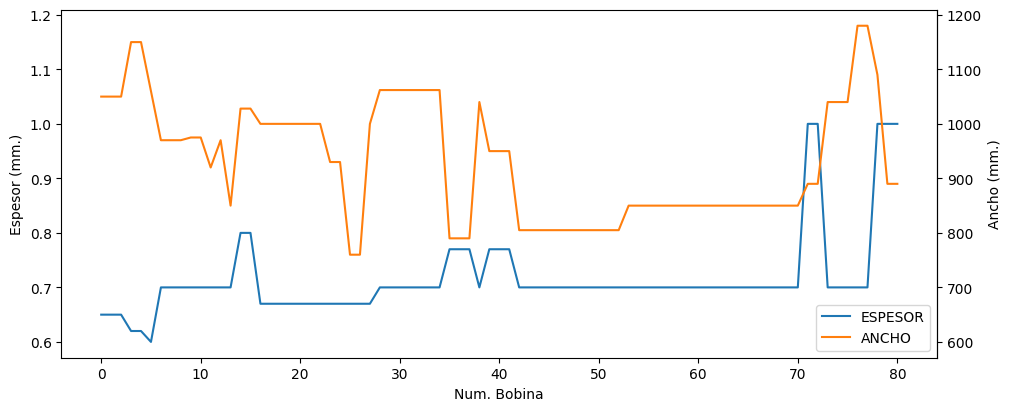

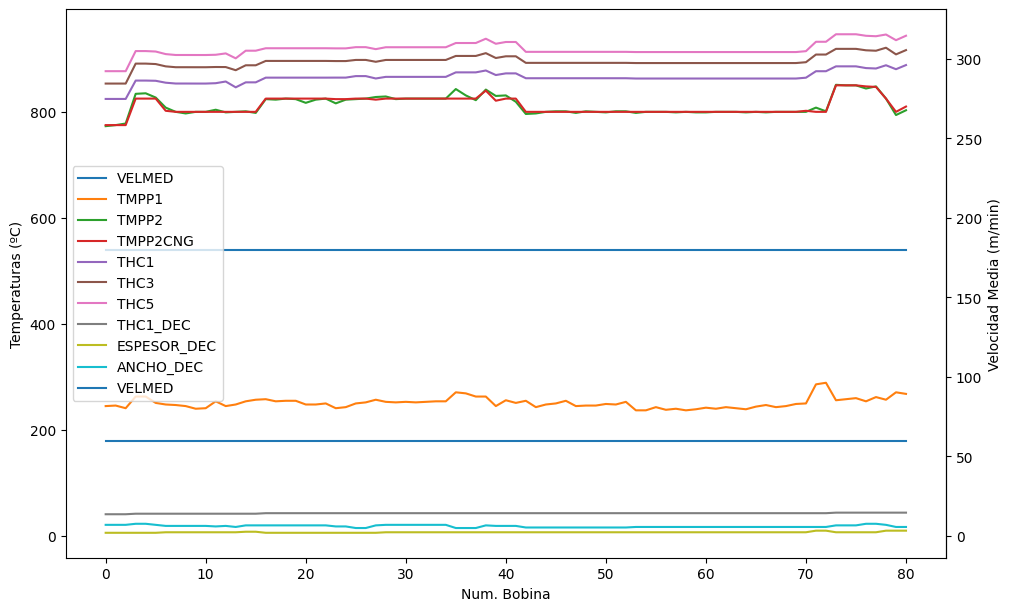

In [17]:
df_sort = df_test_cat[df_test.columns].copy()
df_sort['THC1_DEC'] = df_sort['THC1']//20 #El divisor puede modificarse para agrupar menos o más
df_sort['ESPESOR_DEC'] = df_sort['ESPESOR']*10//1 #El divisor puede modificarse para agrupar menos o más
df_sort['ANCHO_DEC'] = df_sort['ANCHO']//50 #El divisor puede modificarse para agrupar menos o más
# print(df_sort.head(3))
df_sort = df_sort.sort_values(['THC1_DEC','ESPESOR_DEC','CLASACERO']).reset_index()
calcula_diff(df_sort['THC1'],'THC1')
calcula_diff(df_sort['THC3'],'THC3')
calcula_diff(df_sort['THC5'],'THC5')
calcula_diff(df_sort['ANCHO'],'ANCHO')
calcula_diff(df_sort['ESPESOR'],'ESPESOR')
dibuja_proceso(df_sort)

Esta es la lista de las bobinas ordenadas

In [18]:
df_sort.head(10)

,index,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5,THC1_DEC,ESPESOR_DEC,ANCHO_DEC
0,27,23643024,B102G33,1050.0,0.65,3531.0,19130.0,180.0,245.0,773.0,775.0,824.349056,853.353793,876.715864,41.0,6.0,21.0
1,28,23643025,B102G33,1050.0,0.65,2881.0,15430.0,180.0,246.0,775.0,775.0,824.349056,853.353793,876.715864,41.0,6.0,21.0
2,29,23643026,B102G33,1050.0,0.65,3739.0,20180.0,180.0,241.0,778.0,775.0,824.349056,853.353793,876.715864,41.0,6.0,21.0
3,15,23643012,B100F55,1150.0,0.62,1850.0,10500.0,180.0,263.0,834.0,825.0,858.988590,890.997728,914.644357,42.0,6.0,23.0
4,16,23643013,B100F55,1150.0,0.62,1770.0,9930.0,180.0,263.0,835.0,825.0,858.988590,890.997728,914.644357,42.0,6.0,23.0
5,19,23643016,B100F55,1060.0,0.60,3479.0,17550.0,180.0,251.0,827.0,825.0,858.598718,890.150325,913.795078,42.0,6.0,21.0
6,23,23643020,B102G55,970.0,0.70,2856.0,15430.0,180.0,248.0,808.0,802.0,854.990935,885.800610,908.927675,42.0,7.0,19.0
7,24,23643021,B102G55,970.0,0.70,2878.0,15360.0,180.0,247.0,800.0,800.0,853.427529,884.187841,907.247164,42.0,7.0,19.0
8,26,23643023,B102G55,970.0,0.70,2659.0,14260.0,180.0,245.0,797.0,800.0,853.427529,884.187841,907.247164,42.0,7.0,19.0
9,30,23643027,B102G55,975.0,0.70,3390.0,18110.0,180.0,240.0,800.0,800.0,853.366815,884.148711,907.204507,42.0,7.0,19.0


**EJERCICIO: Buscar la forma de ordenar las bobinas para que**:

- La suma de diferencias en valor absoluto de THC1 entre bobinas consecutivas sea < 100
- La suma de diferencias en valor absoluto de THC3 entre bobinas consecutivas sea < 110
- La suma de diferencias en valor absoluto de THC5 entre bobinas consecutivas sea < 120
- La suma de diferencias en valor absoluto de ANCHO entre bobinas consecutivas sea < 2800
- La suma de diferencias en valor absoluto de ESPESOR entre bobinas consecutivas sea < 1.8

**Saca la lista completa de bobinas ordenadas y dibuja la simulación del proceso final.**

In [28]:
import random
import math

# Función para calcular la suma de diferencias en valor absoluto para una característica dada
def sum_abs_diff(feature):
    return sum(abs(df_sort_optimal[feature].iloc[i] - df_sort_optimal[feature].iloc[i+1]) for i in range(len(df_sort_optimal) - 1))

# Función para calcular la energía total del estado actual
def total_energy():
    return sum(sum_abs_diff(feature) for feature in max_diff)

# Función de enfriamiento para el algoritmo de recocido simulado
def cooling_schedule(t):
    return max(0.01, t * 0.99)

# Inicializar el orden de las bobinas de manera aleatoria
current_order = list(range(len(df_sort)))
random.shuffle(current_order)
df_sort_optimal = df_sort.iloc[current_order].reset_index(drop=True)

# Inicializar la temperatura y la energía actual
T = 1000
current_energy = total_energy()

# Realizar el recocido simulado
while T > 1:
    # Seleccionar dos índices aleatorios para intercambiar
    i, j = random.sample(range(len(df_sort)), 2)

    # Intercambiar las bobinas en el orden actual
    current_order[i], current_order[j] = current_order[j], current_order[i]
    df_sort_optimal = df_sort.iloc[current_order].reset_index(drop=True)

    # Calcular la nueva energía
    new_energy = total_energy()

    # Calcular el cambio de energía
    delta_energy = new_energy - current_energy

    # Si el cambio de energía es negativo o aceptamos el cambio según la probabilidad de Boltzmann
    if delta_energy < 0 or random.random() < math.exp(-delta_energy / T):
        current_energy = new_energy
    else:
        # Si no se acepta el cambio, revertir el intercambio
        current_order[i], current_order[j] = current_order[j], current_order[i]
        df_sort_optimal = df_sort.iloc[current_order].reset_index(drop=True)

    # Reducir la temperatura
    T = cooling_schedule(T)

# Mostrar el DataFrame con el orden óptimo de las bobinas
print(df_sort_optimal)


    index    CODBOB CLASACERO   ANCHO  ESPESOR   LARGO     PESO  VELMED  \
0      58  23643055   K011B55   850.0     0.70  3432.0  15970.0   180.0   
1      64  23653002   K011F57   850.0     0.70  3511.0  16380.0   180.0   
2      54  23643051   K011F57   850.0     0.70  3456.0  16120.0   180.0   
3      69  23653008   B100F55   790.0     0.77  2010.0   9550.0   180.0   
4      70  23653009   B100F55   790.0     0.77  3112.0  14950.0   180.0   
..    ...       ...       ...     ...      ...     ...      ...     ...   
76     80  23653024   B100F55  1090.0     1.00  1826.0  15350.0   180.0   
77      1  23633054   B105F55  1040.0     0.70  3240.0  18370.0   180.0   
78     79  23653023   B103G55   890.0     1.00  1997.0  14000.0   180.0   
79     13  23643010   B100F55  1000.0     0.67  3174.0  16840.0   180.0   
80      3  23633056   B105F55  1040.0     0.70  3513.0  19980.0   180.0   

    TMPP1  TMPP2  TMPP2CNG        THC1        THC3        THC5  THC1_DEC  \
0   248.0  800.0     80

# ENTREGA

**Todos los pasos realizados deberán ser explicados con detalle en un documento PDF. El nombre del archivo deberá incluir lo siguiente 'PROYECTO2_NombreDelAlumnoSinAcentos.PDF'. Ejemplo: PROYECTO2_PEPITO_PEREZ.PDF**

Si usas Colab, recuerde guardar sus cambios en su repositorio utilizando la opción "Save a copy in GitHub..." del menú File.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# Definir los algoritmos y los rangos de hiperparámetros
models_params = [
    ('Ridge', Ridge(), {'feature_selection__estimator__alpha': [0.1, 0.5, 1.0]}),  # Ajustar 'alpha' dentro de SelectFromModel
    ('KNeighborsRegressor', KNeighborsRegressor(), {'model__n_neighbors': [5, 10, 15]}),
    ('MLPRegressor', MLPRegressor(max_iter=2000), {'model__hidden_layer_sizes': [(50,), (100,), (200,)], 'model__alpha': [0.0001, 0.001, 0.01]}),
    ('DecisionTreeRegressor', DecisionTreeRegressor(), {'model__max_depth': [5, 10, 15], 'model__min_samples_leaf': [1, 5, 10]})
]

# Modelos para THC1, THC3 y THC5
best_models_thc = {}

for target in ['THC1', 'THC3', 'THC5']:
    print(f"\nBuscando el mejor modelo para {target}:")
    selected_features = ['ESPESOR', 'LARGO', 'ANCHO']  # Características seleccionadas anteriormente
    X = df_train[selected_features]
    y = df_train[target]

    best_rmse = float('inf')
    for name, model, params in models_params:
        print(f"\nBuscando el mejor modelo con {name}...")
        pipeline = Pipeline([
            ('feature_selection', SelectFromModel(Ridge(alpha=0.5))),
            ('model', model)
        ])

        grid_search = GridSearchCV(pipeline, params, cv=5, scoring='neg_root_mean_squared_error')
        grid_search.fit(X, y)

        if -grid_search.best_score_ < best_rmse:
            best_rmse = -grid_search.best_score_
            best_models_thc[target] = (name, grid_search.best_estimator_)

        print(f"Mejor RMSE encontrado: {-grid_search.best_score_}")
        print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")

# Imprimir los mejores modelos encontrados para THC1, THC3 y THC5
for target, (name, model) in best_models_thc.items():
    print(f"\nMejor modelo encontrado para {target}: {name}")
    print(f"Mejor RMSE: {-grid_search.best_score_}")



Buscando el mejor modelo para THC1:


NameError: name 'df_train' is not defined